# Model training

## Import libraries

The following command must be executed for balancing:

```conda install -c conda-forge imbalanced-learn```

In [2]:
%pip install -q -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import math

In [2]:
# Tensorflow may not be installed on every system

from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasClassifier

## Methods

In [8]:
def truncate(number, digits) -> float:
    # Helper method that truncate scores to four decimals
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


def get_nested(data, *args):
    # Helper method that returns the value of a nested dictionary
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])
    return None


def get_scores(y_test, y_predicted):
    # Method that returns different scores for the passed parameters
    digits = 4
    scores = {
        'Accuracy': truncate(accuracy_score(y_test, y_predicted), digits),
        'Recall': truncate(recall_score(y_test, y_predicted), digits),
        'Precision': truncate(precision_score(y_test, y_predicted), digits),
        'F1 score': truncate(f1_score(y_test, y_predicted), digits),
        'F2 score': truncate(fbeta_score(y_test, y_predicted, beta=2), digits)
    }
    return scores


def print_scores(all_scores):
    # Method that prints a table of the passed scores
    header_row = "{header:<20}".format(header="Estimator")
    for score in list(all_scores.values())[0]:
        header_row+="{header:>15}".format(header=score)
    print(header_row,"\n")

    for estimator in all_scores.keys():
        current_row = "{estimator:<20}".format(estimator=estimator)
        estimator_scores = all_scores.get(estimator)
        for score in estimator_scores:
            score_value = get_nested(all_scores, estimator, score)
            current_row+="{score_value:>15}".format(score_value=score_value)
        print(current_row)
        

def print_best_params(estimator_params):
    # Method that prints the best parameters
    for estimator in estimator_params.keys():
        print("Best parameters for "+estimator+": ")
        parameters = estimator_params.get(estimator)
        for parameter in parameters:
            print(parameter+": "+str(get_nested(estimator_params, estimator, parameter)))
            

def plot_roc(title, ax, y_test, y_predicted):
    # Method that plots the ROC for the passed parameters
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

    ax.set_title('Receiver Operating Characteristic (ROC) - '+title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    

def plot_feature_importance(title, ax, estimator, X_train):
    # Method that plots the feature importance for the passed parameters
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh', ax=ax)

    ax.set_title('Feature Importance for '+title)


def plot_learning_curve(title, estimator, ax, X, y, cv, scoring):
    # Method that plots the learning curve for the passed parameters
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    ax.set_title("Learning Curve: "+title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()
    
    
def plot_loss(title, fitted_estimator):
    # plot loss during training
    plt.subplot(211)
    plt.title('{} \nLoss'.format(title))
    plt.plot(fitted_estimator.history['loss'], label='train')
    plt.plot(fitted_estimator.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(fitted_estimator.history['accuracy'], label='train')
    plt.plot(fitted_estimator.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
        

def model_evaluate(estimator, parameters, X_train, X_test, y_train, y_test):
    # Method that trains the passed model with the passed parameters and plots the evaluation of it
    scoring = make_scorer(fbeta_score, beta=2)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=parameters,
                                         scoring= scoring,
                                         cv=10,
                                         return_train_score=True,
                                         verbose=3,
                                         n_jobs=-1
                                         )
    # training and prediction
    fitted_estimator = grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    # evaluation of the model
    # TODO BL: @FL @JG should we use cross validation?
    print_scores({estimator.name: get_scores(y_test, y_predicted)})
    print_best_params({estimator.name: grid_search_estimator.best_params_})

    figure = plt.figure(figsize=(15, 15))
    figure_index = 1
    number_of_rows = 2
    number_of_columns = 2

    # plot loss and accuracy 
    # TODO only enable for keras 
    # plot_loss(title=estimator.name, fitted_estimator=fitted_estimator)
    
    # plot roc
    ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
    plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
    figure_index += 1
    

    
    # plot feature importance in case of forest estimator
    if estimator==Estimator.forest_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_feature_importance(title=estimator.name, ax=ax, estimator=grid_search_estimator.best_estimator_, X_train=X_train)
        figure_index += 1

    # plot learning curve in case of nn estimator
    if estimator==Estimator.nn_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_learning_curve(title=estimator.name, estimator=estimator.value, ax=ax, X=X_train, y=y_train, cv=cv, scoring=scoring)
        figure_index += 1
        
    if estimator==Estimator.log_regr_estimator:
        # TODO implement table output
        val = 0 # TODO
        headers = ["Coefficient", "value"]
        print_template = ""
        for i in range(len(headers)):
            k = len(headers[i])
            print_template += "{" + str(i) + ":" + str(k+2) + "}|"
        print(print_template.format(*headers))
        print(print_template.format(estimator.intercept_, val))
        for coef in estimator.coef_:
            print(print_template.format(coef, val))
    plt.show()
    
    return grid_search_estimator

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [5]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split and reduce dataset (reduction only for test purposes)
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.5, random_state = 42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.9, random_state = 42, stratify=y_train)

# Balance training data
# X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

data_dict = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
print(y_train.value_counts(), y_test.value_counts())

0    14620
1     1369
Name: HeartDisease, dtype: int64 0    131591
1     12317
Name: HeartDisease, dtype: int64


## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

Dummy Classifier             0.8433         0.0854         0.0853         0.0854         0.0854


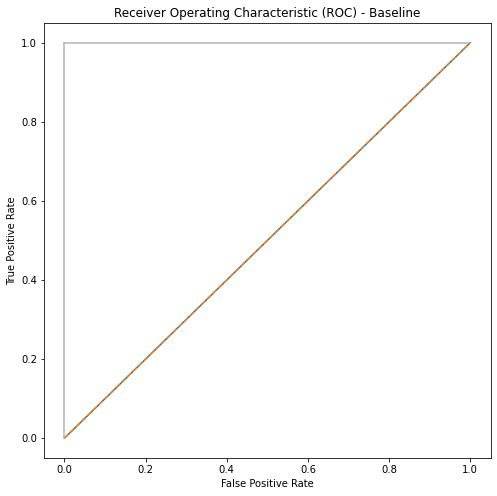

In [5]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

print_scores({'Dummy Classifier':get_scores(y_test, y_predicted)})
plot_roc(title='Baseline', ax=plt.figure(figsize=(8, 8)).add_subplot(), y_test=y_test, y_predicted=y_predicted)
plt.show()

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

To find out which modeling method with which parameters best fits to our task, we define a set of modeling methods, train them with different parameters (hyperparameter tuning) and evaluate the results.

In [21]:
# Create DNN model
def create_model(dropout_rate, hidden_layer_sizes=(30, 30), activation='relu'):
    # create model
    model = Sequential()
    model.add(Input(shape=(X_train.columns.size,)))
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense(hidden_layer_size, activation=activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
              
    return model

# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    nn_estimator=MLPClassifier(random_state=1)
    forest_estimator=RandomForestClassifier()
    svc_estimator=SVC(random_state=0)
    log_regr_estimator=LogisticRegression(random_state=42)
    dnn_estimator=KerasClassifier(model=create_model, verbose=0, hidden_layer_sizes=(30, 30), activation='sigmoid', dropout_rate=0.0)
    xgb_estimator=GradientBoostingClassifier(max_depth=1, random_state=0)

# Class Weights calculation
neg, pos = np.bincount(y_train)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

# TODO JG: Adjust nn parameters
# Dictionary of parameter grids of the estimators
param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 4, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0: weight_for_0, 1: weight_for_1}],
        'n_estimators': [20, 50, 100, 400, 800, 1000]
    },
    Estimator.svc_estimator: {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0: weight_for_0, 1: weight_for_1}]
    },
    Estimator.nn_estimator: {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes': [(60,30), (150,100,50), (120,80,40), (100,50,30)],
        'max_iter': [300, 500],
    },
#     Estimator.dnn_estimator: {
#         'batch_size': [16, 32, 64],
#         'epochs': [10, 20, 40, 80, 100, 200, 300, 400],
#         'hidden_layer_sizes': [(30, 30), (60, 30), (30, 30, 30), (150, 100, 50)],
#         'activation': ['sigmoid', 'relu', 'tanh', 'selu', 'elu', 'exponential'],
#         'loss': ['binary_crossentropy', 'poisson', 'kl_divergence', 'hinge', 'squared_hinge', 'categorical_hinge'],
#         'optimizer': ['SGD', 'adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl'],
#         'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:4}, {0: weight_for_0, 1: weight_for_1}],
#         'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     },
    Estimator.dnn_estimator: {
        'batch_size': [64],
        'epochs': [400],
        'hidden_layer_sizes': [(512, 256, 128)],
        'activation': ['relu'],
        'loss': ['binary_crossentropy'],
        'optimizer': ['SGD'],
        'class_weight': [{0: weight_for_0, 1: weight_for_1}],
        'dropout_rate': [0.4]
    },
    Estimator.xgb_estimator: {
        'n_estimators': [200, 800, 1000],
        'loss': ['log_loss', 'deviance', 'exponential'],
        'criterion': ['friedman_mse', 'squared_error', 'mse'],
        'max_depth': [2, 5, 10]
        'activation': ['identity', 'logistic', 'tanh', 'relu']
    },
    Estimator.log_regr_estimator: {
        'solver': ['sag', 'saga' ], # TODO check also saga with elasticnet
        'max_iter': [200, 400, 1000], 
        'class_weight': [{0:1, 1:2}, {0:1, 1:1}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:6}] # TODO revise maybe 
    }
}

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

dnn_estimator                0.7406         0.7843         0.2179          0.341          0.516
Best parameters for dnn_estimator: 
activation: relu
batch_size: 64
class_weight: {0: 0.5468194254445964, 1: 5.839663988312637}
dropout_rate: 0.4
epochs: 400
hidden_layer_sizes: (60, 30)
loss: binary_crossentropy
optimizer: SGD


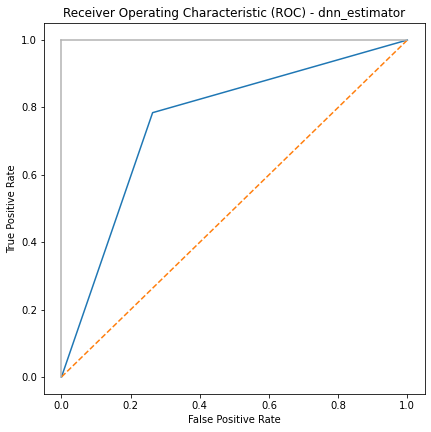

In [13]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


C:\Users\Equus\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

dnn_estimator                0.6349         0.8925         0.1767          0.295         0.4931
Best parameters for dnn_estimator: 
activation: relu
batch_size: 64
class_weight: {0: 0.5468194254445964, 1: 5.839663988312637}
dropout_rate: 0.4
epochs: 400
hidden_layer_sizes: (60, 30)
loss: binary_crossentropy
optimizer: SGD


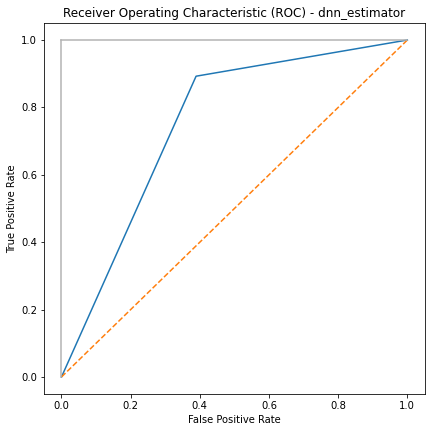

In [16]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

dnn_estimator                 0.773         0.7376         0.2358         0.3574         0.5175
Best parameters for dnn_estimator: 
activation: relu
batch_size: 64
class_weight: {0: 0.5468194254445964, 1: 5.839663988312637}
dropout_rate: 0.4
epochs: 400
hidden_layer_sizes: (512, 256, 128)
loss: binary_crossentropy
optimizer: SGD


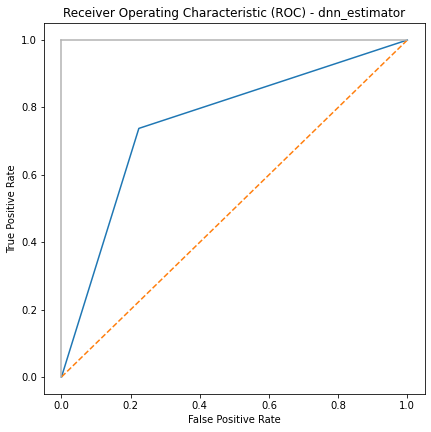

In [22]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [20]:
pd.DataFrame(grid.cv_results_)['rank_test_score']

0    4
1    1
2    5
3    2
4    6
5    3
Name: rank_test_score, dtype: int32

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

xgb_estimator                0.9037         0.1363         0.3437         0.1952          0.155
Best parameters for xgb_estimator: 
criterion: squared_error
loss: log_loss
max_depth: 5
n_estimators: 1000


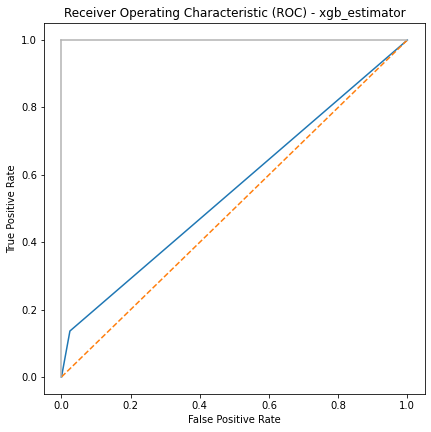

In [10]:
# XGBoost estimator
estimator = Estimator.xgb_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# knn estimator
estimator = Estimator.knn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 6 folds for each of 18 candidates, totalling 108 fits
[CV 1/6] END class_weight={0: 1, 1: 1}, n_estimators=20;, score=(train=0.952, test=0.048) total time=   0.1s
[CV 2/6] END class_weight={0: 1, 1: 1}, n_estimators=20;, score=(train=0.955, test=0.089) total time=   0.1s
[CV 3/6] END class_weight={0: 1, 1: 1}, n_estimators=20;, score=(train=0.949, test=0.089) total time=   0.1s
[CV 4/6] END class_weight={0: 1, 1: 1}, n_estimators=20;, score=(train=0.947, test=0.098) total time=   0.1s
[CV 5/6] END class_weight={0: 1, 1: 1}, n_estimators=20;, score=(train=0.954, test=0.093) total time=   0.1s
[CV 6/6] END class_weight={0: 1, 1: 1}, n_estimators=20;, score=(train=0.957, test=0.073) total time=   0.1s
[CV 1/6] END class_weight={0: 1, 1: 1}, n_estimators=50;, score=(train=0.987, test=0.032) total time=   0.3s
[CV 2/6] END class_weight={0: 1, 1: 1}, n_estimators=50;, score=(train=0.991, test=0.058) total time=   0.3s
[CV 3/6] END class_weight={0: 1, 1: 1}, n_estimators=50;, score=(t

[CV 2/6] END class_weight={0: 0.5468194254445964, 1: 5.839663988312637}, n_estimators=20;, score=(train=0.953, test=0.068) total time=   0.1s
[CV 3/6] END class_weight={0: 0.5468194254445964, 1: 5.839663988312637}, n_estimators=20;, score=(train=0.953, test=0.069) total time=   0.1s
[CV 4/6] END class_weight={0: 0.5468194254445964, 1: 5.839663988312637}, n_estimators=20;, score=(train=0.953, test=0.084) total time=   0.1s
[CV 5/6] END class_weight={0: 0.5468194254445964, 1: 5.839663988312637}, n_estimators=20;, score=(train=0.958, test=0.068) total time=   0.1s
[CV 6/6] END class_weight={0: 0.5468194254445964, 1: 5.839663988312637}, n_estimators=20;, score=(train=0.940, test=0.099) total time=   0.1s
[CV 1/6] END class_weight={0: 0.5468194254445964, 1: 5.839663988312637}, n_estimators=50;, score=(train=0.994, test=0.059) total time=   0.3s
[CV 2/6] END class_weight={0: 0.5468194254445964, 1: 5.839663988312637}, n_estimators=50;, score=(train=0.991, test=0.048) total time=   0.3s
[CV 3/

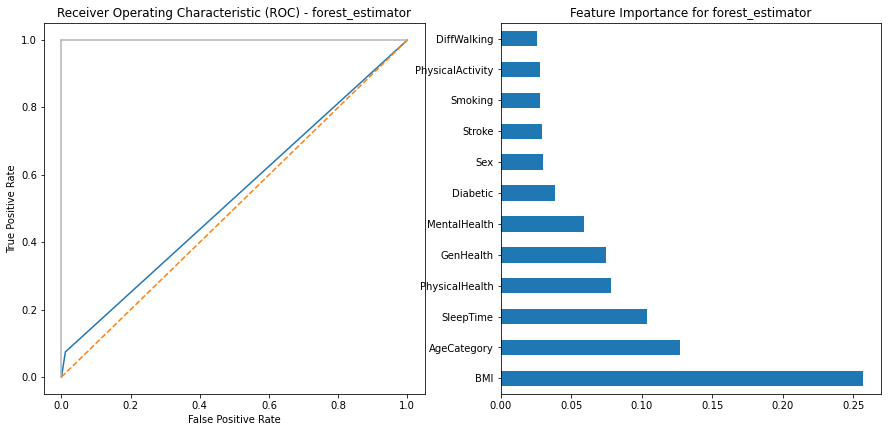

GridSearchCV(cv=6, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 0.5468194254445964,
                                           1: 5.839663988312637}],
                         'n_estimators': [20, 50, 100, 400, 800, 1000]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [44]:
# random forest estimator
estimator = Estimator.forest_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

nn_estimator                  0.871         0.2727         0.2608         0.2666         0.2702
Best parameters for nn_estimator: 
activation: tanh
alpha: 0.0001
hidden_layer_sizes: (150, 100, 50)
learning_rate: constant
max_iter: 300
solver: adam


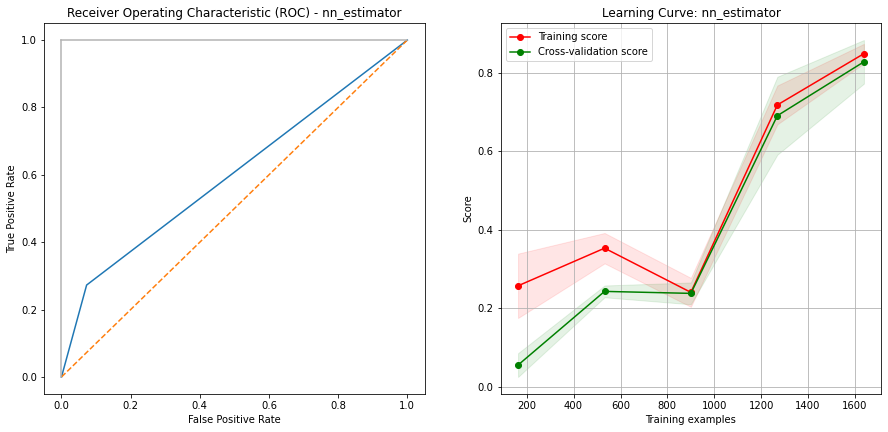

In [30]:
# nn estimator
estimator = Estimator.nn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

svc_estimator                0.6054         0.9125         0.1678         0.2836         0.4835
Best parameters for svc_estimator: 
class_weight: {0: 1, 1: 2}
kernel: linear


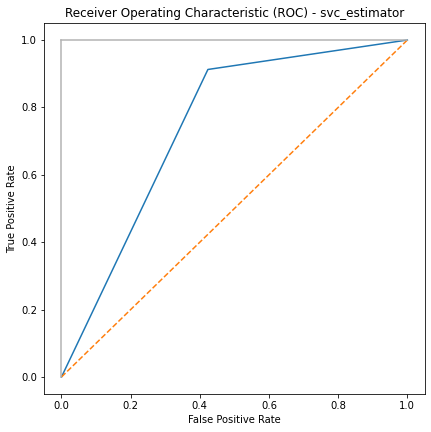

GridSearchCV(cv=4, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1.0, 1: 1.0}],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [58]:
# svc estimator
estimator = Estimator.svc_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# svc estimator not oversampled
estimator = Estimator.svc_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\flola\

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

log_regr_estimator           0.3993         0.9744         0.1224         0.2175         0.4073
Best parameters for log_regr_estimator: 
class_weight: {0: 1, 1: 6}
max_iter: 100
solver: saga
Coefficient  |value  |


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AttributeError: 'Estimator' object has no attribute 'intercept_'

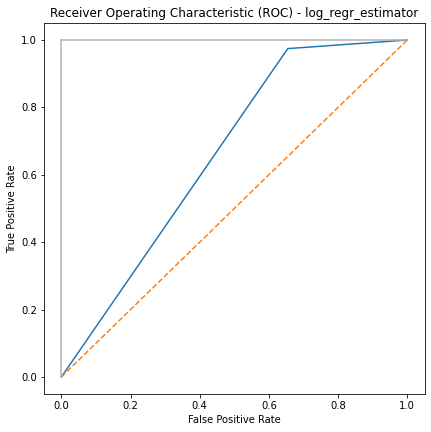

In [10]:
# logistic regression estimator
estimator = Estimator.log_regr_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

**Conclusion**

TODO: Add conclusion

## Final model

After having determined the best model and the best parameters for it in the step of model selection, we now apply this in the following.

In [26]:
## TODO implement